# Bootstrap Confidence Intervals

### Calculating confidence intervals with the bootstrap involves two steps:
- Calculate a Population of Statistics
- Calculate Confidence Intervals

## 1. Calculate a Population of Statistics

The first step is to use the bootstrap procedure to resample the original data a number of times and calculate the statistic of interest.

The dataset is sampled with replacement. This means that each time an item is selected from the original dataset, it is not removed, allowing that item to possibly be selected again for the sample.

The statistic is calculated on the sample and is stored so that we build up a population of the statistic of interest.

The number of bootstrap repeats defines the **variance** of the estimate, and **more is better**, often hundreds or thousands.

We can demonstrate this step with the following pseudocode.

```` python
statistics = []
for i in bootstraps:
	sample = select_sample_with_replacement(data)
	stat = calculate_statistic(sample)
	statistics.append(stat)
````

## 2. Calculate Confidence Interval
Now that we have a population of the statistics of interest, we can calculate the confidence intervals.

This is done by first ordering the statistics, then selecting values at the chosen percentile for the confidence interval. The chosen percentile in this case is called **alpha**.

For example, if we were interested in a confidence interval of 95%, then alpha would be `0.95` and we would select the value at the 2.5% percentile as the lower bound and the 97.5% percentile as the upper bound on the statistic of interest.

For example, if we calculated 1,000 statistics from 1,000 bootstrap samples, then the lower bound would be the 25th value and the upper bound would be the 975th value, assuming the list of statistics was ordered.

In this, we are calculating a non-parametric confidence interval that does not make any assumption about the functional form of the distribution of the statistic. This confidence interval is often called the **empirical confidence interval**.

We can demonstrate this with pseudocode below.

````python
ordered = sort(statistics)
lower = percentile(ordered, (1-alpha)/2)
upper = percentile(ordered, alpha+((1-alpha)/2))
````

# Bootstrap Model Performance

**The bootstrap can be used to evaluate the performance of machine learning algorithms.**

The size of the sample taken each iteration may be limited to 60% or 80% of the available data. This will mean that there will be some samples that are not included in the sample. These are called **out of bag (OOB)** samples.

A model can then be trained on the data sample each bootstrap iteration and evaluated on the out of bag samples to give a performance statistic, which can be collected and from which confidence intervals may be calculated.

We can demonstrate this process with the following pseudocode.

````python
statistics = []
for i in bootstraps:
	train, test = select_sample_with_replacement(data, size)
	model = train_model(train)
	stat = evaluate_model(test)
	statistics.append(stat)
````

# Calculate Classification Accuracy Confidence Interval

This section demonstrates how to use the bootstrap to calculate an empirical confidence interval for a machine learning algorithm on a real-world dataset using the Python machine learning library scikit-learn.

This section assumes you have Pandas, NumPy, and Matplotlib installed. If you need help setting up your environment, see the tutorial:

[How to Setup a Python Environment for Machine Learning and Deep Learning with Anaconda](http://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/)

First, download the [Pima Indians dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv) and place it in your current working directory with the filename “pima–indians-diabetes.data.csv” (update: download here).

We will load the dataset using Pandas.

In [5]:
import random
import numpy as np
import pandas as pd

# load dataset
data = pd.read_csv('pima-indians-diabetes.data.csv', header=None)
values = data.values

data.head()

array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

Next, we will configure the bootstrap. We will use 1,000 bootstrap iterations and select a sample that is 50% the size of the dataset.

In [3]:
# configure bootstrap
n_iterations = 1000
n_size = int(len(data) * 0.50)

Next, we will iterate over the bootstrap.

The sample will be selected with replacement using the resample() function from sklearn. Any rows that were not included in the sample are retrieved and used as the test dataset. Next, a decision tree classifier is fit on the sample and evaluated on the test set, a classification score calculated, and added to a list of scores collected across all the bootstraps.

In [4]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    # fit model
    model = DecisionTreeClassifier()
    model.fit(train[:,:-1], train[:,-1])
    # evaluate model
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    #print(score)
    stats.append(score)

Once the scores are collected, a histogram is created to give an idea of the distribution of scores. We would generally expect this distribution to be Gaussian, perhaps with a skew with a symmetrical variance around the mean.

Finally, we can calculate the empirical confidence intervals using the [percentile() NumPy function](https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html). A 95% confidence interval is used, so the values at the `2.5` and 97.5 percentiles are selected.

Putting this all together, the complete example is listed below.

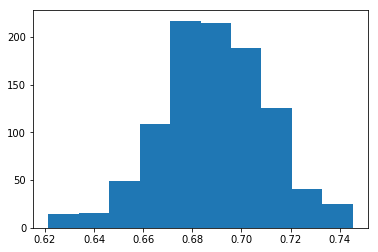

p min =  2.500000000000002
p max =  97.5 97.5 True
95.0 confidence interval 0.64454 and 0.73291


In [9]:
from matplotlib import pyplot

# plot scores
pyplot.hist(stats)
pyplot.show()

# confidence interval
alpha = 0.95

#calculate
p_min = ((1.0-alpha)/2.0) * 100
print("p min = ", p_min)
lower = max(min(stats), np.percentile(stats, p_min))
p_max = (alpha+((1.0-alpha)/2.0)) * 100
p_max_2 = 100-p_min
print("p max = ", p_max, p_max_2, p_max == p_max_2)
upper = min(max(stats), np.percentile(stats, p_max))
print('%.1f confidence interval %.5f and %.5f' % (alpha*100, lower, upper))